In [2]:
%matplotlib inline
import numpy as np
import scipy
from scipy import stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import distributions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
sns.set_style('white')
sns.set_context('paper')
from scipy.special import gammaln

# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #7
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, March 23th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Kidney Cancer Data Revisited
In this problem we will work with the US Kidney Cancer Data set (by county). This is a dataset of kidney cancer frequencies across the US over 5 years on a per county basis. 

In lecture, we've discussed the potential (and significant) draw backs of drawing conclusions based on raw cancer rates. Addressing these draw backs, we proposed using a Bayesian model to model the data. In the following, you will implement two Bayesian models and examine the adjusted cancer rates per county resulting from these models.

### Part A: Empirical Bayes
Let $N$ be the number of counties; let $y_j$ the number of kidney cancer case for the $j$-th county, $n_j$ the population of the $j$-county and $\theta_j$ be the underlying kidney cancer rate for that county. The following is a Bayesian model for our data:
\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N
\end{aligned}
where $\alpha, \beta$ are hyper-parameters of the model.

(1) Using Empirical Bayes and moment matching, choose appropriate values for the hyperparameters. To do this, consider the **prior-predictive** distribution (also called evidence, the denominator normalization of bayes theorem) of the model: 

$$p(y) = \int p(y \vert \theta) p(\theta) d \theta$$.

(This is as opposed to the posterior predictive: $\int p( y \vert \theta) p(\theta \vert D) d\theta$. Not that in conjugate models such as ours, these two distributions have the same form)

For this model, the prior-predictive is a negative binomial. By matching the mean and the variance of the negative binomial to that from the data you can find $\alpha$ and $\beta$. (Hint: You need to be careful with the $5n_j$ multiplier.) Why the prior-predictive? Because you then "havent seen" individual county data yet.


In [3]:
cancer_data = pd.read_csv('./kcancer.csv')

In [4]:
cancer_data.head(10)

,state,fips,county,countyfips,dc,pop,pct_mortality
0,ALABAMA,1,AUTAUGA,1001,1.0,64915.0,0.000015
1,ALABAMA,1,BALDWIN,1003,15.0,195253.0,0.000077
2,ALABAMA,1,BARBOUR,1005,1.0,33987.0,0.000029
3,ALABAMA,1,BIBB,1007,1.0,31175.0,0.000032
4,ALABAMA,1,BLOUNT,1009,5.0,91547.0,0.000055
5,ALABAMA,1,BULLOCK,1011,0.0,8197.0,0.000000
6,ALABAMA,1,BUTLER,1013,1.0,31722.0,0.000032
7,ALABAMA,1,CALHOUN,1015,12.0,233021.0,0.000051
8,ALABAMA,1,CHAMBERS,1017,0.0,57813.0,0.000000
9,ALABAMA,1,CHEROKEE,1019,0.0,43828.0,0.000000


# Estimate $\alpha$ and $\beta$ based on the prior

From matching the mean and the variance of the prior to the moments of the gamma distribution, the values of $\alpha$ and $\beta$ can be calculated:

$$ \mu = \frac{\alpha}{\beta} $$
$$ \sigma^2 = \frac{\alpha}{\beta^2} $$

In [5]:
mu = (cancer_data['dc']/(5*cancer_data['pop'])).mean()
sigma2 = (cancer_data['dc']/(5*cancer_data['pop'])).var()
sum_yi = cancer_data['dc'].sum()
N = cancer_data.shape[0]

In [6]:
mu, sigma2

(1.1573104708217248e-05, 1.0113340787478882e-10)

In [7]:
beta_emp = mu/sigma2
alpha_emp = mu*beta_emp

In [8]:
alpha_emp,beta_emp

(1.3243571575594935, 114434.04263154732)

In [9]:
thetas = []
for i in range(N):
    y_j = cancer_data['dc'].iloc[i]
    n_j = cancer_data['pop'].iloc[i]
    thetas.append(np.random.gamma(alpha_emp+y_j, 1/(beta_emp+5*n_j), size=10000).mean())
thetas = np.array(thetas) # need the per year rate

## Estimate $\alpha$ and $\beta$ based on the prior predictive

The negative binomial is parameterised by r and p. For this example the prior predictive values of y are given by:

$$ y_j \sim NegBin (\alpha, \frac{\beta}{5n_j}) $$

where:

$$ r = \alpha $$
$$ p =  \frac{5n_j}{5n_j+ \beta}$$

The mean and variance of a negative binomial are given by:

$$ \mu = \frac{rp}{1-p} $$

$$ \sigma^2 = \frac{rp}{(1-p)^2} $$

$$ \sigma^2 = \frac{\mu}{(1-p)} $$

Substituting r and p we get:

$$ \mu = \frac{\alpha * 5n_j}{\beta} $$

$$ \sigma^2 = \frac{\mu(\beta + 5n_j)}{\beta}$$

Resulting in the following experessions for alpha and beta:

$$ \beta = \frac{5n_j \mu}{\sigma^2 - \mu} $$

$$ \alpha = \frac{\mu \beta}{5n_j} $$

In [10]:
mu_ = cancer_data['dc'].mean()
sigma2_ = cancer_data['dc'].var()
n_j_mean = cancer_data['pop'].mean()

In [11]:
beta1 = (5*cancer_data['pop']*cancer_data['dc']).mean()/(sigma2_ - mu_)

In [12]:
beta1

113737.85828851341

In [13]:
alpha1 = ((beta1*cancer_data['dc'])/(5*cancer_data['pop'])).mean()

In [14]:
alpha1

1.3163001432613421

In [20]:
thetas = []
for i in range(N):
    y_j = cancer_data['dc'].iloc[i]
    n_j = cancer_data['pop'].iloc[i]
    thetas.append(np.random.gamma(alpha1+y_j, 1/(beta1+5*n_j), size=10000).mean())
thetas = np.array(thetas) # need the per year rate

The values of alpha and beta obtained using the prior and prior predictive are very similar. 

### Part 1

(2) Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size. Highlight the top 300 raw cancer rates in red. Highlight the bottom 300 raw cancer rates in blue. Finally, on the same plot again, scatter plot the posterior mean cancer rate estimates (pct mortality) vs the county population size, highlight these in green. 

(**Note:** This is the plot (without the corrected green estimates) shown in the lecture notes for this dataset. We have provided the code to produce this plot, which you are free to use or to ignore.)


(3) Using the scatter plot, explain why using the posterior means (from our model) to estimate cancer rates is preferable to studying the raw rates themselves.

(**Hint:** You might find it helpful to review the in-class discussion on this dataset. You might also find it helpful to follow the Rat Tumor Baysian model example.)


In [21]:
# data_df is the dataframe of your data
# estimates is a numpy array of cancer rate estimates, one for each county
def scatter_plot_cancer_rates(data_df, estimates):
    ax = data_df.plot(kind='scatter', x="pop",y="pct_mortality", alpha=0.05, color="grey", figsize=(10,10))
    # NOTE:if you have an older pandas version you should use 
    # "data_df.sort" instead of "data_df.sort_values"
    bot_kcancer_counties = data_df.sort_values(by='pct_mortality',ascending=True)[:300]
    top_kcancer_counties = data_df.sort_values(by='pct_mortality',ascending=False)[:300]
    top_kcancer_counties.plot(kind='scatter',x="pop",y="pct_mortality",alpha=0.07, color="blue", ax=ax, logx=True)
    bot_kcancer_counties.plot(kind='scatter',x="pop",y="pct_mortality",alpha=0.07, color="red", ax=ax, logx=True)
    ax.plot(data_df['pop'], 5 * estimates, '.', alpha=0.1, color="green")
    ax.set_ylim([-0.0001, 0.0003])
    ax.grid()

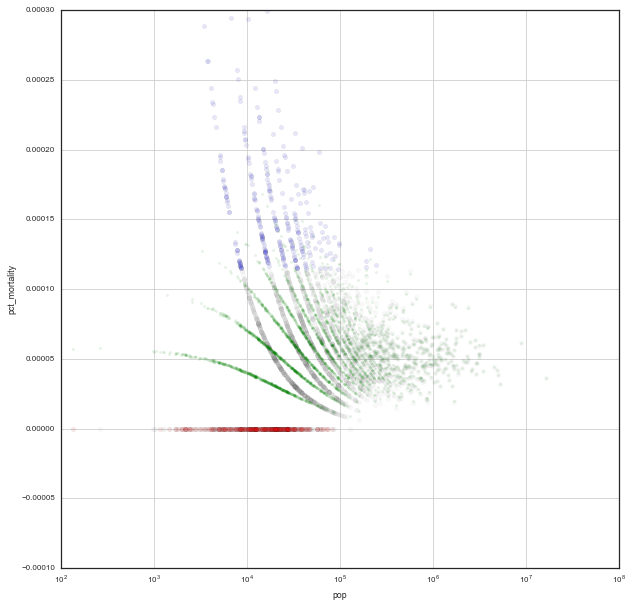

In [22]:
scatter_plot_cancer_rates(cancer_data, np.array(thetas))

## Explain why using the posterior means (from our model) to estimate cancer rates is preferable to studying the raw rates themselves

The raw cancer mortality rates are skewed by the population size of the county. For counties with very small populations, even small numbers of cancer deaths can result in the mortality rate being very large. It therefore does not provide a useful metric for comparing mortality rates between counties. 

When the mortatlity rates are assumed to come from a common prior gamma distribution with the empirically estimated parameters, there is a pooling effect where all the mortality rate are pushed towards the group mean (~0.000005) and there are fewer extreme values. The population size has a smaller effect on the percentage mortality. 

### Part B: Full Bayes
Rather than estimating the hyperparameters $\alpha, \beta$ from the data, in a full Bayesian model we would put additional priors on quantities of which we are uncertain. That is, we can model the kidney cancer rates using a *hierarchical model*.
\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N\\
\alpha &\sim Gamma(a, b)\\
\beta &\sim Gamma(c, d)
\end{aligned}
where $a, b, c, d$ are hyperparameters. 


(1) Analytically derive the full conditional, up constants that are inconsequential for sampling, for each variable in the model. 
  

Start with the joint and then derive the individual conditionals 
\begin{aligned}
p(\theta_j, y_j, \mu, \sigma,\alpha, \beta, a,b,c,d) =  p(y_j|\theta_j)*p(\theta_j|\alpha, \beta)*  p(\alpha|a,b)*p(\beta|c,d)*p(a)*p(b)*p(c)*p(d)
\end{aligned}

\begin{aligned}
p(\theta_j | y_j,  \mu, \sigma) = p(y_j|\theta_j)*p(\theta_j|\alpha, \beta) \\
\end{aligned}

We know that the prior is modelled with a Gamma function and the likelihood with a poission distribution, therefore by conjugacy of the Poission-Gamma model the posterior for $\theta$ is a Gamma function as well. We can prove this as follows:

\begin{aligned}
p(\theta_j | y_j, \mu, \sigma) \propto \left(\frac{{5n_j\theta_j}^y_j e^{-5n_j\theta_j}}{y_j!}\right)* \left(\frac{{\beta}^\alpha}{\Gamma(a)}\right)\theta_j^{\alpha -1}e^{-\beta\theta_j}\\
\end{aligned}

Grouping similar terms together:

\begin{aligned}
p(\theta_j | y_j, \mu, \sigma) \propto \theta_j^{y_j+\alpha -1} e^{-(5n_j + \beta)\theta_j}\\
\end{aligned}

\begin{aligned}
p(\theta_j | y_j, \mu, \sigma) \propto \theta_j^{y_j+\alpha -1} e^{-(5n_j + \beta)\theta_j}\\
\end{aligned}

\begin{aligned}
p(\theta_j | y_j, \mu, \sigma) \propto \left(\frac{(\beta+5n_j)\theta_j^{y_j+\alpha -1} e^{-(5n_j + \beta)\theta_j}}{\Gamma(\alpha + y_i)}\right)\\
\end{aligned}

\begin{aligned}
p(\theta_j | y_j, \alpha, \beta) \propto Gamma\left(\theta_j; y_j + \alpha, \beta + 5n_j\right)\\
\end{aligned}

For $\alpha$ and $\beta$ the conditional distribution can be derived as follows:

\begin{aligned}
p(\alpha, \beta|\theta_j, y_j, \sigma^2) =  \prod_j p(\theta_j|\alpha, \beta)*p(\alpha| a,b)*p(\beta| c,d)
\end{aligned}

Substituting in gamma pdfs:

\begin{aligned}
p(\alpha, \beta|\theta_j, y_j, \sigma^2) =  \prod_j \left(\frac{{\beta}^\alpha}{\Gamma(\alpha)}\theta_j^{a-1}e^{-\theta_j \beta}\right) \left(\frac{{b}^a}{\Gamma(a)}\alpha^{a-1}e^{-\alpha b}\right) \left(\frac{{d}^c}{\Gamma(c)}\beta^{c-1}e^{-\beta d}\right)
\end{aligned}

This can be rearranged to the form:

\begin{aligned}
p(\alpha, \beta|\theta_j, y_j, \sigma^2) =  \left(\frac{{b}^a}{\Gamma(a)}\alpha^{a-1}e^{-\alpha b}\right) \left(\frac{{d}^c}{\Gamma(c)}\beta^{c-1}e^{-\beta d}\right) \frac{{\beta}^{N\alpha}}{\Gamma(\alpha)^N} \prod_j \left(\theta_j^{a-1}e^{-\theta_j \beta}\right)
\end{aligned}

\begin{aligned}
p(\alpha, \beta|\theta_j, y_j, \sigma^2) =  \left(\frac{{b}^a}{\Gamma(a)}\alpha^{a-1}e^{-\alpha b}\right) \left(\frac{{d}^c}{\Gamma(c)}\beta^{c-1}e^{-\beta d}\right) \beta^{N\alpha}\Gamma(\alpha)^{-N} \prod_j \left(\theta_j^{a-1}\right)e^{-\beta\sum_j\theta_j}
\end{aligned}

\begin{aligned}
p(\alpha, \beta | y_j, \theta_j, \sigma^2) &\propto \beta^{N\alpha}\Gamma(\alpha)^{-N}\prod_j\theta_j^{\alpha} \exp\left\{ - \beta\sum_j \theta_j \right\} * Gamma\left(\alpha; a, b \right) * Gamma\left(\beta; c, d \right) \\
\end{aligned}

The term: 

$$\beta^{N\alpha}\Gamma(\alpha)^{-N}\prod_j\theta_j^{\alpha} \exp\left\{ - \beta\sum_j \theta_j \right\}$$

is the product of gamma pdfs evaluated at each value of theta. 

A possible set of correct final forms of your conditionals looks like the following:
      
\begin{aligned}
p(\theta_j | y_j, \mu, \sigma) &\propto Gamma\left(\theta_j; y_j + \alpha, \beta + 5n_j\right)\\
p(\alpha, \beta | y_j, \theta_j, \sigma^2) &\propto \beta^{N\alpha}\Gamma(\alpha)^{-N} \prod_j\theta_j^{\alpha} \exp\left\{ - \beta\sum_j \theta_j \right\} * Gamma\left(\alpha; a, b \right) * Gamma\left(\beta; c, d \right) \\
\end{aligned}



(2) Implement a Metropolis-Hastings-in-Gibbs sampler (like in rat tumors) to produce sets of theta-values, $\{ \theta_j: j = 1, \ldots, N\}$. Note that for updating some variables, you may need to use a Metropolis-Hastings step (see Rat Tumor example). 

  We suggest the following settings for your MH-in-Gibbs sampler, but please feel free to use your own:
  
  - Gibbs sweeps: 100,000
  - $a = 9, b = 6, c = 9, d = 0.00001$
  - Starting points: $\alpha_0 = \alpha_{\text{emperical bayes}}, \beta_0 = \beta_{\text{emperical bayes}}$
  - proposal distribution: $\mathcal{N}\left([\alpha, \beta], \left[\begin{array}{cc} 0.1 & 0 \\ 0 & 1000\end{array}\right]\right)$
  - burn in: 10%
  - thinning: 10
  
  We do not guarantee convergence after 100,000 sets of samples under these conditions. In fact, ***convergence in a untweaked sampler maybe unlikely after only 100,000 Gibbs sweeps***. 

  You are responsible for performing your own convergence tests and diagnostics.

  **Note:** to sanity check your implementation, you may wish to implement this model in PyMC3 and compare your results. Note that because you model is hand tuned to deal with the conditionals and to sample straight away from the Gamma's, it will likely run faster)
  
  

- **Extra Credit:** Tweak the settings in your sampler (including number of sweeps) in order to achieve convergence. For example, do you need to sample $\alpha$ and $\beta$ jointly? Can sampling them individually speed up your sampler? Only do this after you have a complete homework. It is a rabbit hole.



(3) Using your samples, produce a pct mortality vs county population scatter plot exactly as in Part A.

In [23]:
a = 9
b = 6
c = 9
d = 0.00001

def proposal(alp,bet):
    cov = [[0.001, 0], [0, 1000]]
    return np.random.multivariate_normal([alp,bet], cov)

prior_a = stats.gamma(a,scale=1.0/b)

prior_b = stats.gamma(c,scale=1.0/d)

likelihood_theta = lambda alp, bet: stats.gamma(alp,scale=1.0/bet)

In [24]:
numthetas=cancer_data.shape[0]

# sampling from conditional posterior for the theta
draw_thetas = lambda a_,b_: stats.gamma.rvs(a_+cancer_data['dc'],scale=1.0/(b_+5*cancer_data['pop']), size=numthetas)

# conditional posterior (pdf) for alpha beta
def log_cond_alpha_beta(alp,bet, thetas):
    return np.sum(np.log(likelihood_theta(alp, bet).pdf(thetas))) + np.log(prior_a.pdf(alp)) + np.log(prior_b.pdf(bet))

# using the above pdfs we draw for alpha and beta in MH fashion
def draw_alpha_beta(alp,bet,thetas,proposal, accepts):
    alp_star, bet_star = proposal(alp, bet)  # propose a new alpha and beta
    num = log_cond_alpha_beta(alp_star,bet_star, thetas) 
    den = log_cond_alpha_beta(alp,bet, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den): 
        accepted=1
    else:
        accepted=0
    accepts['alpha_beta'] = accepts['alpha_beta'] + accepted
    if accepted:
        return alp_star, bet_star
    else:
        return alp, bet

In [25]:
totaltraces=100000
burnin=0.1*totaltraces

alphas=np.empty(totaltraces)
betas=np.empty(totaltraces)
thetas=np.empty((totaltraces, numthetas))

# start positions
alphas[0]=alpha_emp
betas[0]=beta_emp
thetas[0,:] = 0.0001


In [26]:
start = time.clock()
accepteds={'alpha_beta':0}
for m in np.arange(1,totaltraces):
    if (m%10000 == 0):
        print(m)
    alphas[m], betas[m] = draw_alpha_beta(alphas[m-1],betas[m-1],thetas[m-1,:], proposal, accepteds)
    thetas[m,:] = draw_thetas(alphas[m],betas[m])

print("sampling took: ", time.clock()-start, " seconds.")

10000
20000
30000
40000
50000
60000
70000
80000
90000
('sampling took: ', 525.695029, ' seconds.')


In [38]:
accepteds['alpha_beta']

61603

In [39]:
accepteds['alpha_beta']/totaltraces

0

In [40]:
#remove burnin samples and thin
thin=10
burnin=1000
alphatrace=alphas[burnin+1:totaltraces:thin]
betatrace=betas[burnin+1:totaltraces:thin]
thetastrace=thetas[burnin+1:totaltraces:thin,:]
print(thetastrace.shape, alphatrace.shape)

((9900, 3113), (9900,))


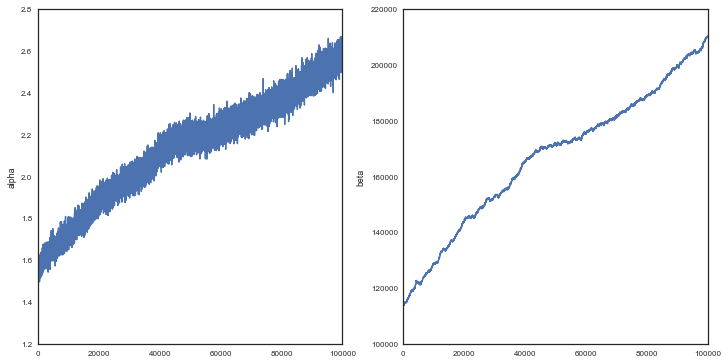

In [41]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(alphas)
plt.ylabel('alpha')
plt.subplot(1,2,2)
plt.plot(betas)
plt.ylabel('beta')

The alpha and beta values do not appear to have converged within 100000 iterations but due to time constraints, the sampler was only run for this duration. 

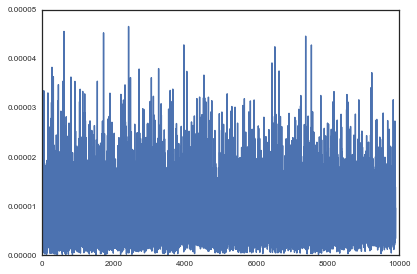

In [42]:
plt.plot(thetastrace[:, 100])

In [43]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

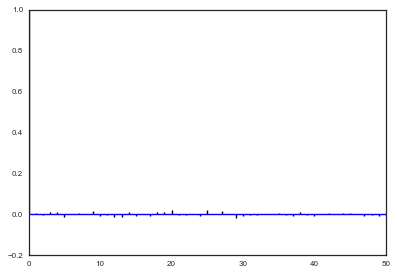

In [44]:
corrplot(thetastrace[:, 100])

After burnin and thinning therer is no autocorrelation in the trace of the thetas. 

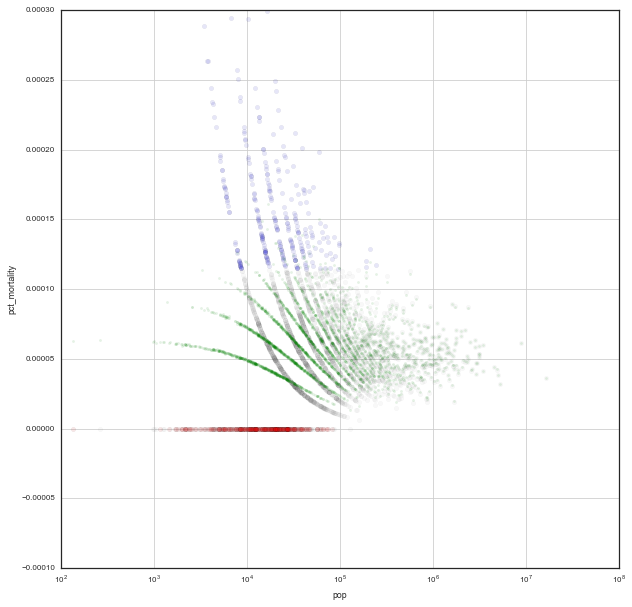

In [45]:
scatter_plot_cancer_rates(cancer_data, np.mean(thetastrace, axis=0))

With a full bayesian model, there are hyperpriors on  alpha and beta which themselves are uncertain and have variability. 

Compared to the purely empirical Bayes, with the fully Bayesian model, the perecent mortality has slightly more variation with population and there is a larger distribution of mortality rates about the group mean. 

Overall, the result of the model is to reduce the extreme values of of percentage mortality caused by having either very small or very large population sizes. There is a smaller overall range in the mortality rates comapred to the raw estimates of mortality based purely on the counts of incidence and population. 